## Consuming data using Kafka and Visualise (20%)
In this task, we will implement an Apache Kafka consumer to consume the data from Part 2.  
  
Important:   
-	In this part, Kafka consumers are used to consume the streaming data published from task 2.8.

In [ ]:
# Gemini kafka consumer v2
# Import all necessary libraries
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from threading import Thread, Lock
import time
import atexit

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration & Global State ---
HOST_IP = "192.168.0.6" # Use your machine's IP
TOPIC_BUILDING = "building_6h"
TOPIC_SITE = "site_daily"

# Thread-safe global data stores
# Format: {"YYYY-MM-DD": {"0-6h": {"bldg_id": val, ...}, ...}, ...}
building_data_store = {}
# Format: {"YYYY-MM-DD": {"site_id": val, ...}, ...}
site_data_store = {}

# A single lock for both stores
data_lock = Lock()

# Global Y-axis maximums
# We set them to the minimums you requested.
yaxis_max_building = 500.0
yaxis_max_site = 5000.0

# List to keep track of consumers for cleanup
consumers = []

def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    try:
        consumer = KafkaConsumer(
            topic,
            bootstrap_servers=[f'{HOST_IP}:9092'],
            auto_offset_reset='earliest', # Start from the beginning
            value_deserializer=lambda x: json.loads(x.decode('utf-8'))
        )
        consumers.append(consumer) # Add to list for cleanup
        print(f"Successfully connected to topic: {topic}")
        return consumer
    except Exception as e:
        print(f"Failed to connect to topic {topic}: {e}")
        return None

# --- 2. Consumer Thread Functions ---
# These threads ONLY consume data and update the global stores.

def consumer_thread_building():
    """Consumes 'building_6h' data and populates the global store."""
    consumer = connect_kafka_consumer(TOPIC_BUILDING)
    if consumer is None:
        return

    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    
    try:
        for message in consumer:
            msg = message.value
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h')
            date_str = msg.get('date') # e.g., "2022-01-05"

            if not all([bldg_id, time_bucket, val, date_str]):
                print(f"[{TOPIC_BUILDING}] Skipping malformed message: {msg}")
                continue
            
            with data_lock:
                # Ensure the date entry exists
                if date_str not in building_data_store:
                    building_data_store[date_str] = {bucket: {} for bucket in time_buckets}
                
                # Ensure time bucket exists (should be redundant, but safe)
                if time_bucket not in building_data_store[date_str]:
                    building_data_store[date_str][time_bucket] = {}
                    
                # Update the value
                building_data_store[date_str][time_bucket][str(bldg_id)] = val

    except Exception as e:
        print(f"Error in consumer for {TOPIC_BUILDING}: {e}")
    finally:
        print(f"Closing consumer for {TOPIC_BUILDING}")
        consumer.close()

def consumer_thread_site():
    """Consumes 'site_daily' data and populates the global store."""
    consumer = connect_kafka_consumer(TOPIC_SITE)
    if consumer is None:
        return
        
    all_sites = [str(i) for i in range(16)]

    try:
        for message in consumer:
            msg = message.value
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            date_str = msg.get('date')

            if site_id is None or val is None or date_str is None:
                print(f"[{TOPIC_SITE}] Skipping malformed message: {msg}")
                continue
                
            with data_lock:
                # Ensure the date entry exists, initialized with all sites
                if date_str not in site_data_store:
                    site_data_store[date_str] = {site: 0 for site in all_sites}
                
                # Update the value for the specific site
                site_data_store[date_str][str(site_id)] = val

    except Exception as e:
        print(f"Error in consumer for {TOPIC_SITE}: {e}")
    finally:
        print(f"Closing consumer for {TOPIC_SITE}")
        consumer.close()


# --- 3. Plotting Functions (Called by the Plotter Thread) ---
# These functions ONLY read from the stores and draw.

def draw_building_plot(fig, axes, target_date_str):
    """Draws the 2x2 building plot for a specific target date."""
    global yaxis_max_building
    
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    ax_map = {
        "0-6h": axes[0, 0], "6-12h": axes[0, 1],
        "12-18h": axes[1, 0], "18-24h": axes[1, 1]
    }
    
    # Get all data for the target day (or an empty dict)
    data_for_day = building_data_store.get(target_date_str, {})
    max_val_found = 0.0

    for bucket in time_buckets:
        ax = ax_map[bucket]
        ax.cla() # Clear the specific subplot
        
        bucket_data = data_for_day.get(bucket, {})
        
        # Sort by value (highest first) and take Top 8
        sorted_items = sorted(bucket_data.items(), key=lambda item: item[1], reverse=True)
        top_8_items = sorted_items[:8]

        if top_8_items:
            labels, values = zip(*top_8_items)
            ax.bar(labels, values)
            ax.set_xticklabels(labels, rotation=75)
            # Find the max value in this plot for Y-axis scaling
            max_val_found = max(max_val_found, max(values))
        
        ax.set_title(f"Time Bucket: {bucket}")
        ax.set_ylabel("Total Power (6h)")
    
    # Update the global Y-axis max
    # It's the max of its old value, the new value, or the min 500
    yaxis_max_building = max(yaxis_max_building, max_val_found, 500)
    
    # Apply the uniform Y-axis limit to all subplots
    for ax in axes.flatten():
        ax.set_ylim(bottom=0, top=yaxis_max_building * 1.1) # Add 10% padding
        
    fig.suptitle(f"Building Top 8 Power (Date: {target_date_str})", y=1.02)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

def draw_site_plot(fig, axes, target_date_str, prev_date_str):
    """Draws the 2x1 site plot for a target date and previous date."""
    global yaxis_max_site
    
    ax_prev, ax_curr = axes[0], axes[1]
    all_sites = [str(i) for i in range(16)]
    
    # Create a default dict for all sites at 0
    default_day_data = {site: 0 for site in all_sites}
    
    # Get data for previous and current day, falling back to the default
    prev_data = site_data_store.get(prev_date_str, default_day_data)
    curr_data = site_data_store.get(target_date_str, default_day_data)
    
    # Get values in the correct 0-15 order
    prev_values = [prev_data.get(site, 0) for site in all_sites]
    curr_values = [curr_data.get(site, 0) for site in all_sites]

    # Find max value for Y-axis scaling
    max_val_found = 0.0
    if prev_values: max_val_found = max(max_val_found, max(prev_values))
    if curr_values: max_val_found = max(max_val_found, max(curr_values))
    
    # Update global Y-axis max
    yaxis_max_site = max(yaxis_max_site, max_val_found, 5000)
    
    # --- Redraw BOTH subplots ---
    ax_prev.cla()
    ax_prev.bar(all_sites, prev_values, color='gray')
    ax_prev.set_title(f"Previous Day's Usage (Date: {prev_date_str})")
    ax_prev.set_ylabel("Total Power (Daily)")
    ax_prev.set_ylim(bottom=0, top=yaxis_max_site * 1.1) # 10% padding

    ax_curr.cla()
    ax_curr.bar(all_sites, curr_values, color='blue')
    ax_curr.set_title(f"Target Day's Usage (Date: {target_date_str})")
    ax_curr.set_xlabel("Site ID")
    ax_curr.set_ylabel("Total Power (Daily)")
    ax_curr.set_ylim(bottom=0, top=yaxis_max_site * 1.1)

    fig.tight_layout()

# --- 4. Plotter & Manager Thread ---
# This thread runs every 5s to update plots, print debug info, and prune data.

def plotter_and_manager_thread(fig_building, axes_building, fig_site, axes_site):
    """The main loop for redrawing, debugging, and data pruning."""
    
    while True:
        try:
            # --- 1. Date Calculation ---
            today = datetime.now().date()
            # Plot data from 7 days ago
            target_plot_date = today - timedelta(days=7)
            # Show the day before that for the "previous" site plot
            prev_plot_date = today - timedelta(days=8)
            
            target_str = target_plot_date.isoformat()
            prev_str = prev_plot_date.isoformat()
            
            # --- 2. Acquire Lock and Perform All Tasks ---
            with data_lock:
                # --- A. Plotting ---
                draw_building_plot(fig_building, axes_building, target_str)
                draw_site_plot(fig_site, axes_site, target_str, prev_str)

                # --- B. Redraw Canvas ---
                fig_building.canvas.draw()
                fig_site.canvas.draw()

                # --- C. Debugger ---
                print("\n" * 5) # Clear screen a bit
                print("--- DEBUGGER: DATA STORE STATUS (Press 'i' twice or Interrupt Kernel to stop) ---")
                print(f"Plotting Target Date: {target_str} (Previous: {prev_str})")
                
                print("\n[Site Daily Store Counts]:")
                sorted_site_keys = sorted(site_data_store.keys())
                if not sorted_site_keys:
                    print("  (No data)")
                for date_str in sorted_site_keys:
                    # Count non-zero entries
                    count = sum(1 for v in site_data_store[date_str].values() if v > 0)
                    print(f"  {date_str}: {count} / 16 sites reported")

                print("\n[Building 6h Store Counts]:")
                sorted_bldg_keys = sorted(building_data_store.keys())
                if not sorted_bldg_keys:
                    print("  (No data)")
                for date_str in sorted_bldg_keys:
                    b_data = building_data_store[date_str]
                    c0 = len(b_data.get("0-6h", {}))
                    c1 = len(b_data.get("6-12h", {}))
                    c2 = len(b_data.get("12-18h", {}))
                    c3 = len(b_data.get("18-24h", {}))
                    print(f"  {date_str}: [0-6h]: {c0}, [6-12h]: {c1}, [12-18h]: {c2}, [18-24h]: {c3}")

                # --- D. Pruning Old Data ---
                # We prune anything older than the "previous plot date"
                prune_keys_b = [k for k in building_data_store if k < prev_str]
                prune_keys_s = [k for k in site_data_store if k < prev_str]
                
                for key in prune_keys_b:
                    del building_data_store[key]
                for key in prune_keys_s:
                    del site_data_store[key]
                
                if prune_keys_b or prune_keys_s:
                    print(f"\nPruned {len(prune_keys_b)} building keys and {len(prune_keys_s)} site keys.")

            # --- 3. Wait for 5 seconds ---
            # We use plt.pause, which is required for %matplotlib notebook
            plt.pause(5.0)

        except Exception as e:
            print(f"[Plotter Error] {e}. Retrying in 5s.")
            time.sleep(5)

# --- 5. Main Execution Block ---

def cleanup_consumers():
    """Function to close all Kafka consumers on exit."""
    print("Shutting down all Kafka consumers...")
    for c in consumers:
        c.close()

# Register the cleanup function to run on kernel shutdown
atexit.register(cleanup_consumers)

try:
    # Initialize plots
    print("Initializing plots...")
    # Plot 1: 2x2 grid for Building data
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    # Plot 2: 2x1 grid for Site data
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()
    print("Plots initialized.")

    # Create and start threads
    # Set daemon=True so they stop when the kernel is interrupted
    thread_building = Thread(target=consumer_thread_building, daemon=True)
    thread_site = Thread(target=consumer_thread_site, daemon=True)
    thread_plotter = Thread(
        target=plotter_and_manager_thread, 
        args=(fig_building, axes_building, fig_site, axes_site),
        daemon=True
    )
    
    print("Starting all threads...")
    thread_building.start()
    thread_site.start()
    thread_plotter.start()
    
    print("--- All consumer and plotter threads are running. ---")
    print("--- Interrupt the kernel (press 'i' twice or stop button) to end. ---")

except Exception as e:
    print(f"Failed to start threads: {e}")
    cleanup_consumers() # Clean up if startup failed

# Note: Because the threads are daemons, this cell will "finish"
# but the threads will keep running in the background.
# The plots will update.
# To stop everything, you MUST interrupt or restart the kernel.

In [ ]:
# Chatgpt file upload attempt
# Stream buffering + throttled plotter for building_6h and site_daily
# Paste into your notebook and run. Requires: pandas, matplotlib, kafka-python (or adapt to your consumer)

import threading
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from collections import defaultdict, deque
from kafka3 import KafkaConsumer
    # If you already have a consumer object in your notebook, you can skip kafka usage below
    # and call stream_plotter.process_message(stream_name, msg_dict) directly.

# ---------- CONFIG ----------
REDRAW_INTERVAL = 5.0  # seconds
MAX_DAYS_TO_KEEP = 7   # keep up to 7 days of data
# Minimum y-limits
MIN_Y_BUILDING_6H = 500
MIN_Y_SITE_DAILY = 5000

# Topics (change to match your topics)
TOPICS = {
    'building_6h': 'topic_building_6h',   # replace with your kafka topic
    'site_daily': 'topic_site_daily'      # replace with your kafka topic
}

KAFKA_SETTINGS = {
    'bootstrap_servers': ['192.168.0.6:9092'],
    'auto_offset_reset': 'earliest',
    'enable_auto_commit': True,
    # 'group_id': 'a2b_consumer_group',  # set if needed
    # add security configs if required
}
# ----------------------------

class StreamPlotter:
    def __init__(self, redraw_interval=REDRAW_INTERVAL):
        # buffers: {stream_name: {date_string: list-of-dicts/DataFrame}}
        self.buffers = defaultdict(lambda: defaultdict(list))
        self.lock = threading.Lock()
        self.redraw_interval = redraw_interval
        self._stop_event = threading.Event()
        self._thread = None

        # Matplotlib setup: two subplots (one for building_6h, one for site_daily)
        plt.ion()
        self.fig, (self.ax_building, self.ax_site) = plt.subplots(1, 2, figsize=(14,6))
        self._init_plots()

    def _init_plots(self):
        # Building 6h - bar container placeholder
        self.building_bar_container = None
        self.ax_building.set_title('building_6h (one-week-old day)')
        self.ax_building.set_xlabel('building_id')
        self.ax_building.set_ylabel('value')

        # site_daily - grouped bar for two days (day-7 and day-8)
        self.site_bar_container = None
        self.ax_site.set_title('site_daily (1-week-old day AND previous day)')
        self.ax_site.set_xlabel('site_id')
        self.ax_site.set_ylabel('daily_total')

        plt.tight_layout()
        plt.show()

    def stop(self):
        self._stop_event.set()
        if self._thread:
            self._thread.join(timeout=2.0)

    def start(self):
        if self._thread and self._thread.is_alive():
            return
        self._thread = threading.Thread(target=self._run_loop, daemon=True)
        self._thread.start()

    def _run_loop(self):
        while not self._stop_event.is_set():
            try:
                self.redraw()
            except Exception as e:
                print("Plotter redraw error:", e)
            time.sleep(self.redraw_interval)

    # ---------- message ingestion ----------
    def process_message(self, stream_name, msg: dict):
        """
        msg expected to contain at least:
          - 'ts' : timestamp (ISO string or integer seconds/ms) OR 'timestamp'
          - 'value' : numeric
          - 'building_id' or 'site_id'
        Adapt this mapping if your messages use different keys.
        """
        # map fields (adjust if your payload uses different names)
        ts_candidates = [msg.get('ts'), msg.get('timestamp'), msg.get('weather_ts')]
        ts_raw = next((x for x in ts_candidates if x is not None), None)
        value = msg.get('value', msg.get('energy', None))
        if value is None:
            return  # nothing to store

        # id extraction
        building_id = msg.get('building_id')
        site_id = msg.get('site_id') or msg.get('site')

        # parse timestamp robustly
        dt = None
        if ts_raw is None:
            dt = pd.Timestamp.utcnow()
        else:
            try:
                # if unix-int (seconds or ms)
                if isinstance(ts_raw, (int, float, np.integer, np.floating)):
                    # heuristic: if > 10**12 treat as ms
                    if ts_raw > 1e12:
                        dt = pd.to_datetime(int(ts_raw), unit='ms', utc=True)
                    else:
                        dt = pd.to_datetime(int(ts_raw), unit='s', utc=True)
                else:
                    # try parsing string
                    dt = pd.to_datetime(str(ts_raw), utc=True)
            except Exception:
                try:
                    dt = pd.to_datetime(str(ts_raw), errors='coerce')
                except:
                    dt = pd.Timestamp.utcnow()

        if dt.tzinfo is None:
            dt = dt.tz_localize('UTC')
        # convert to local date if you want Melbourne timezone; here we just use date part in UTC for consistency
        date_str = dt.date().isoformat()  # YYYY-MM-DD

        record = {
            'ts': dt,
            'value': float(value),
            'building_id': building_id,
            'site_id': site_id,
            'raw': msg
        }

        with self.lock:
            self.buffers[stream_name][date_str].append(record)
            # drop older than MAX_DAYS_TO_KEEP
            self._prune_old_dates_locked(stream_name)

    def _prune_old_dates_locked(self, stream_name):
        # called with lock held
        dates = sorted(self.buffers[stream_name].keys())
        if not dates:
            return
        # keep only last MAX_DAYS_TO_KEEP dates
        keep = set(dates[-MAX_DAYS_TO_KEEP:])
        for d in list(self.buffers[stream_name].keys()):
            if d not in keep:
                del self.buffers[stream_name][d]

    # ---------- redraw logic ----------
    def redraw(self):
        """
        This function is called every REDRAW_INTERVAL seconds.
        It picks the "1-week-old" target date (today - 7 days) and plots:
          - building_6h : the day 7 days ago (single day)
          - site_daily  : the day 7 days ago AND the previous day (2 days)
        If the required date is missing, it will skip plotting that stream but still print the debug counts.
        """
        now = pd.Timestamp.utcnow().normalize()
        target_date = (now - pd.Timedelta(days=7)).date()            # day 7 days ago
        prev_date = (now - pd.Timedelta(days=8)).date()              # day 8 days ago (for site_daily second bar)

        target_str = target_date.isoformat()
        prev_str = prev_date.isoformat()

        # Acquire the buffer snapshot under lock
        with self.lock:
            snapshot = {s: {d: list(self.buffers[s][d]) for d in self.buffers[s]} for s in self.buffers}

        # Debug stats
        self._print_debug(snapshot)

        # --- building_6h plot (single day target_str) ---
        if 'building_6h' in snapshot and target_str in snapshot['building_6h']:
            recs = snapshot['building_6h'][target_str]
            df = pd.DataFrame([{
                'building_id': r['building_id'],
                'value': r['value']
            } for r in recs if r['building_id'] is not None])
            if df.empty:
                # nothing to plot
                self.ax_building.cla()
                self.ax_building.set_title('building_6h (no data for {})'.format(target_str))
            else:
                # Sum/aggregate per building if there are multiple readings
                agg = df.groupby('building_id')['value'].sum().reset_index()
                # Sort by value descending and select top N to keep plot stable
                topn = agg.sort_values('value', ascending=False).head(30)
                x = topn['building_id'].astype(str).tolist()
                y = topn['value'].tolist()

                self.ax_building.cla()
                bars = self.ax_building.bar(x, y)
                self.ax_building.set_title(f'building_6h - {target_str} (top {len(x)})')
                self.ax_building.set_xlabel('building_id')
                self.ax_building.set_ylabel('value')
                # y-limit at least MIN_Y_BUILDING_6H, expand if needed
                ymax = max(max(y) if y else 0, MIN_Y_BUILDING_6H)
                self.ax_building.set_ylim(0, ymax * 1.05)
                # annotate small bars to reduce flicker/noise
                for rect in bars:
                    h = rect.get_height()
                    if h > 0.05 * ymax:
                        self.ax_building.text(rect.get_x() + rect.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontsize=8)
        else:
            # No data yet for that day
            self.ax_building.cla()
            self.ax_building.set_title(f'building_6h (no data for {target_str})')
            self.ax_building.set_xlabel('building_id')
            self.ax_building.set_ylabel('value')
            self.ax_building.set_ylim(0, MIN_Y_BUILDING_6H)

        # --- site_daily plot (two days: target_str and prev_str) ---
        # Expect site ids are 0-15 fixed for site_daily per your note
        if 'site_daily' in snapshot:
            # build DataFrame for both days if exist
            df_list = []
            for dstr in (prev_str, target_str):
                recs = snapshot['site_daily'].get(dstr, [])
                if recs:
                    df_list.append(pd.DataFrame([{'site_id': r['site_id'], 'value': r['value'], 'date': dstr} for r in recs if r['site_id'] is not None]))
            if df_list:
                df_sites = pd.concat(df_list, ignore_index=True)
                # Aggregate daily totals per site per date
                agg_site = df_sites.groupby(['date', 'site_id'])['value'].sum().reset_index()
                # pivot for grouped bar chart
                pivot = agg_site.pivot(index='site_id', columns='date', values='value').fillna(0)
                # ensure site_id order 0..15 if present; otherwise sorted unique
                site_index = sorted(pivot.index.tolist())
                pivot = pivot.reindex(site_index)

                self.ax_site.cla()
                n_sites = len(site_index)
                indices = np.arange(n_sites)
                width = 0.35
                cols = pivot.columns.tolist()
                if len(cols) == 2:
                    left = pivot[cols[0]].values
                    right = pivot[cols[1]].values
                    b1 = self.ax_site.bar(indices - width/2, left, width, label=cols[0])
                    b2 = self.ax_site.bar(indices + width/2, right, width, label=cols[1])
                    self.ax_site.set_xticks(indices)
                    self.ax_site.set_xticklabels([str(int(s)) for s in site_index], rotation=45)
                else:
                    # only one day available
                    single = pivot[cols[0]].values
                    b1 = self.ax_site.bar(indices, single, width, label=cols[0])
                    self.ax_site.set_xticks(indices)
                    self.ax_site.set_xticklabels([str(int(s)) for s in site_index], rotation=45)

                self.ax_site.set_title(f'site_daily - {", ".join(cols)}')
                ymax_site = max(pivot.max().max(), MIN_Y_SITE_DAILY)
                self.ax_site.set_ylim(0, ymax_site * 1.05)
                self.ax_site.set_xlabel('site_id')
                self.ax_site.set_ylabel('daily_total')
                self.ax_site.legend()
            else:
                self.ax_site.cla()
                self.ax_site.set_title(f'site_daily (no data for {prev_str} or {target_str})')
                self.ax_site.set_ylim(0, MIN_Y_SITE_DAILY)
        else:
            self.ax_site.cla()
            self.ax_site.set_title('site_daily (no data)')
            self.ax_site.set_ylim(0, MIN_Y_SITE_DAILY)

        # final draw (single canvas update)
        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

    def _print_debug(self, snapshot):
        # Print counts of data points per date for each stream
        lines = []
        for s in sorted(snapshot.keys()):
            counts = {d: len(snapshot[s][d]) for d in snapshot[s]}
            sorted_counts = ", ".join([f"{d}:{counts[d]}" for d in sorted(counts.keys())])
            lines.append(f"{s} -> {sorted_counts}")
        if not lines:
            print(f"[{datetime.utcnow().isoformat()}] No data in buffers yet.")
        else:
            print(f"[{datetime.utcnow().isoformat()}] Buffer stats:")
            for l in lines:
                print("  ", l)

# End of StreamPlotter class

# -----------------------
# Usage examples
# -----------------------
stream_plotter = StreamPlotter()
stream_plotter.start()

# Example: If you already have a Kafka consumer, call stream_plotter.process_message(stream_name, parsed_msg)
# Example message:
# stream_plotter.process_message('building_6h', {'ts': 1698000000, 'value': 250.3, 'building_id': 101})
# stream_plotter.process_message('site_daily', {'ts': '2025-10-17T00:00:00Z', 'value': 12345, 'site_id': 3})

# ---------- Optional: start simple kafka consumers in backgro


Main: Creating log output widget...


Output()

Main: Initializing plots...


<IPython.core.display.Javascript object>


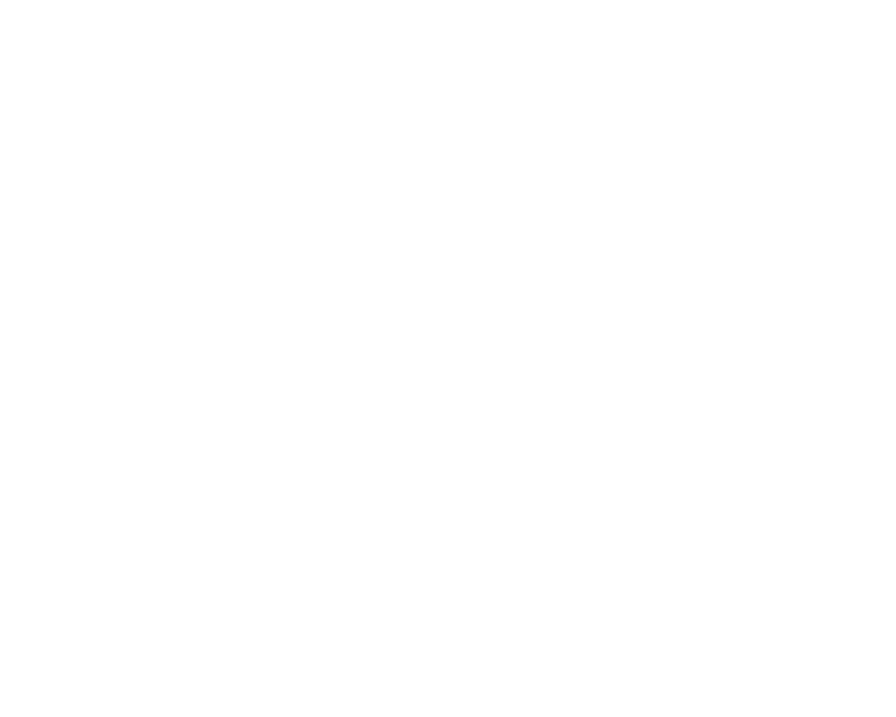

<IPython.core.display.Javascript object>


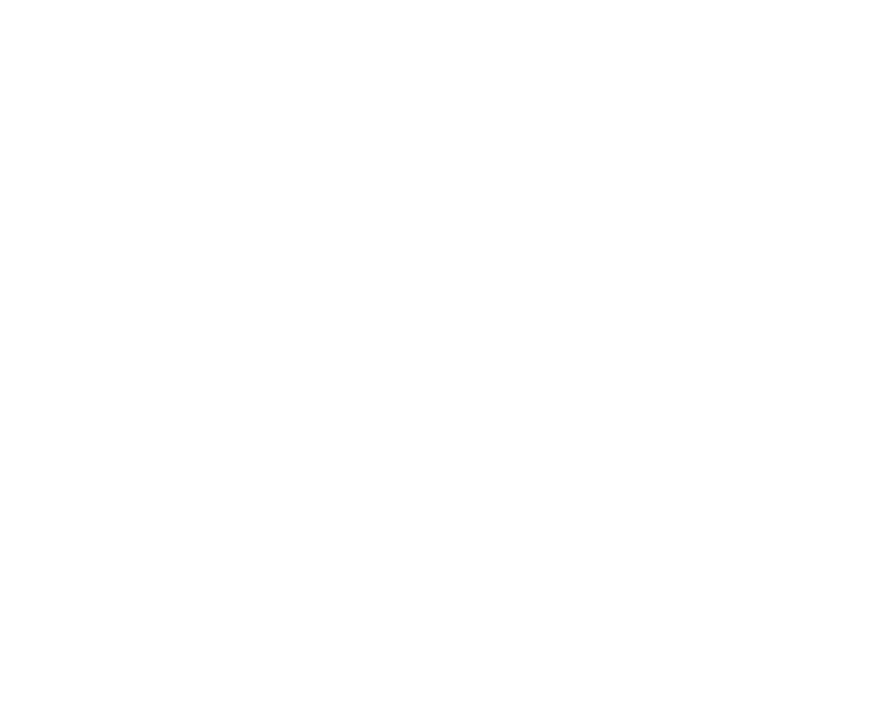

Main: Plot figures created.


In [ ]:
# Gemini attempt This is your corrected Task 3 cell with a Jupyter Log Widget
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread, Lock
import time
import copy
import ipywidgets as widgets
from IPython.display import display

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"
PLOT_UPDATE_INTERVAL = 5 # 5 seconds
DATA_BUFFER_DAYS = 7 # Store 7 days of data

# --- 2. Shared Data Stores, Lock, and Max Y-Values ---
data_lock = Lock()
data_store_building = {}
data_store_site = {}
max_y_building = 500
max_y_site = 5000

# --- 3. Kafka Connection Function (Unchanged) ---
def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', 
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        request_timeout_ms=10000 
    )

# --- 4. Consumer Functions (Data Collection ONLY) ---
# --- NOTICE: All print calls are now 'with log_widget: print(...)' ---

def consume_building_6h(consumer, log_widget):
    """
    Consumes from 'building_6h'.
    This function ONLY updates the shared data_store_building.
    """
    global max_y_building
    with log_widget:
        print(f"[{topic_building}] Starting consumer thread...")
    
    try:
        with log_widget:
            print(f"[{topic_building}] Consumer connected. Waiting for messages...")
        
        msg_count = 0
        for message in consumer:
            msg_count += 1
            if msg_count % 100 == 0: 
                with log_widget:
                    print(f"[{topic_building}] ... {msg_count} messages received ...")

            msg = message.value
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h') # This can be 0.0
            date_str = msg.get('date', "Unknown Date") 
            
            # --- THIS IS THE FIX ---
            # We now check for 'None' explicitly, just like in consume_site_daily.
            # This prevents 0.0 values from being filtered out.
            if bldg_id is None or time_bucket is None or val is None or date_str == "Unknown Date":
                continue
            # --- END OF FIX ---
                
            bldg_id_str = str(bldg_id)

            with data_lock:
                if date_str not in data_store_building:
                    data_store_building[date_str] = {
                        "0-6h": {}, "6-12h": {}, "12-18h": {}, "18-24h": {}
                    }
                data_store_building[date_str][time_bucket][bldg_id_str] = val
                if val > max_y_building:
                    max_y_building = val

    except Exception as e:
        with log_widget:
            print(f"CRITICAL Error in consumer for {topic_building}: {e}")
    finally:
        with log_widget:
            print(f"Closing consumer for {topic_building}")
        consumer.close()


def consume_site_daily(consumer, log_widget):
    """
    Consumes from 'site_daily'.
    This function ONLY updates the shared data_store_site.
    """
    global max_y_site
    with log_widget:
        print(f"[{topic_site}] Starting consumer thread...")
    all_sites = [str(i) for i in range(16)]
    
    try:
        with log_widget:
            print(f"[{topic_site}] Consumer connected. Waiting for messages...")
        
        msg_count = 0
        for message in consumer:
            msg_count += 1
            if msg_count % 20 == 0: # Print a heartbeat every 20 messages
                 with log_widget:
                    print(f"[{topic_site}] ... {msg_count} messages received ...")
            
            msg = message.value
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            date_str = msg.get('date', "Unknown Date") 
            
            if site_id is None or val is None or date_str == "Unknown Date":
                continue
                
            site_id_str = str(site_id)

            with data_lock:
                if date_str not in data_store_site:
                    data_store_site[date_str] = {site: 0 for site in all_sites}
                data_store_site[date_str][site_id_str] = val
                if val > max_y_site:
                    max_y_site = val

    except Exception as e:
        with log_widget:
            print(f"CRITICAL Error in consumer for {topic_site}: {e}")
    finally:
        with log_widget:
            print(f"Closing consumer for {topic_site}")
        consumer.close()

# --- 5. Plotting Function (Runs in its own Thread) ---

def redraw_plots(fig_building, axes_building, fig_site, axes_site, log_widget):
    """
    This function runs in a loop, redrawing all plots
    every PLOT_UPDATE_INTERVAL seconds.
    """
    with log_widget:
        print(f"Starting redraw thread. Updates every {PLOT_UPDATE_INTERVAL}s.")
        
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    ax_map = {
        "0-6h": axes_building[0, 0],
        "6-12h": axes_building[0, 1],
        "12-18h": axes_building[1, 0],
        "18-24h": axes_building[1, 1]
    }
    all_sites = [str(i) for i in range(16)]
    
    while True:
        try:
            time.sleep(PLOT_UPDATE_INTERVAL)
            with log_widget:
                print(f"\n[{datetime.now()}] Plotter waking up...")
            
            local_store_building = {}
            local_store_site = {}
            sorted_dates = []
            current_max_y_bldg = 500
            current_max_y_site = 5000
            
            with data_lock:
                all_dates_set = set(data_store_building.keys()) | set(data_store_site.keys())
                sorted_dates_all = sorted(list(all_dates_set))
                
                if len(sorted_dates_all) > DATA_BUFFER_DAYS:
                    date_to_drop = sorted_dates_all[0]
                    with log_widget:
                        print(f"Data buffer full ({len(sorted_dates_all)} days). Dropping oldest: {date_to_drop}")
                    data_store_building.pop(date_to_drop, None)
                    data_store_site.pop(date_to_drop, None)
                
                local_store_building = copy.deepcopy(data_store_building)
                local_store_site = copy.deepcopy(data_store_site)
                current_max_y_bldg = max_y_building
                current_max_y_site = max_y_site
                
                final_dates_set = set(local_store_building.keys()) | set(local_store_site.keys())
                sorted_dates = sorted(list(final_dates_set))

                # --- Debugger Print ---
                with log_widget:
                    print("--- DEBUGGER: Data Points Per Date ---")
                    if not sorted_dates:
                        print("  (No data collected yet)")
                    for date in sorted_dates:
                        site_count = len(local_store_site.get(date, {}))
                        bldg_buckets = local_store_building.get(date, {})
                        bldg_count = sum(len(bldg_buckets.get(bucket, {})) for bucket in bldg_buckets)
                        print(f"  {date}: Site_Daily_Points={site_count}, Building_6h_Points={bldg_count}")
                    print(f"Total unique dates stored: {len(sorted_dates)}")
                    print("----------------------------------------")

            # --- Plotting Gate ---
            if len(sorted_dates) < DATA_BUFFER_DAYS:
                with log_widget:
                    print(f"Waiting for {DATA_BUFFER_DAYS} days of data. Collected {len(sorted_dates)}/{DATA_BUFFER_DAYS}.")
                
                # Clear plots to show we are waiting
                fig_building.suptitle(f"Waiting for {DATA_BUFFER_DAYS} days of data...", y=1.02)
                for ax in axes_building.flat: 
                    ax.cla()
                    ax.set_title("Waiting for data...")
                    ax.set_ylim(bottom=0, top=current_max_y_bldg * 1.1)
                fig_building.canvas.draw()
                
                ax_prev, ax_curr = axes_site[0], axes_site[1]
                ax_prev.cla()
                ax_prev.set_title(f"Waiting for {DATA_BUFFER_DAYS} days of data...")
                ax_prev.set_ylim(bottom=0, top=current_max_y_site * 1.1)
                ax_curr.cla()
                ax_curr.set_title("Waiting for data...")
                ax_curr.set_ylim(bottom=0, top=current_max_y_site * 1.1)
                fig_site.canvas.draw()
                
                continue 

            # --- Plotting Logic (Buffer is full) ---
            with log_widget:
                print("Buffer full. Plotting most recent data.")
            
            building_plot_date_str = sorted_dates[-1]
            current_plot_date_str = sorted_dates[-1]
            previous_plot_date_str = sorted_dates[-2]
            
            # --- Plot Building Data ---
            data_for_date = local_store_building.get(building_plot_date_str, {})
            fig_building.suptitle(f"Building Top 8 Power Consumption (Date: {building_plot_date_str})", 
                                 y=1.02)
            ylim_bldg = current_max_y_bldg * 1.1

            for bucket in time_buckets:
                ax = ax_map[bucket]
                bucket_data = data_for_date.get(bucket, {})
                sorted_items = sorted(bucket_data.items(), key=lambda item: item[1], reverse=True)
                top_8_items = sorted_items[:8]

                ax.cla()
                if top_8_items:
                    labels, values = zip(*top_8_items)
                    ax.bar(labels, values)
                    ax.set_xticklabels(labels, rotation=75)
                
                ax.set_title(f"Time Bucket: {bucket}")
                ax.set_ylabel("Total Power (6h)")
                ax.set_ylim(bottom=0, top=ylim_bldg)
            
            fig_building.tight_layout(rect=[0, 0, 1, 0.96])
            fig_building.canvas.draw()

            # --- Plot Site Data ---
            ylim_site = current_max_y_site * 1.1
            default_site_data = {site: 0 for site in all_sites}
            current_day_data = local_store_site.get(current_plot_date_str, default_site_data)
            previous_day_data = local_store_site.get(previous_plot_date_str, default_site_data)
            
            curr_values = [current_day_data.get(site, 0) for site in all_sites]
            prev_values = [previous_day_data.get(site, 0) for site in all_sites]

            # Plot Previous Day
            ax_prev = axes_site[0]
            ax_prev.cla()
            ax_prev.bar(all_sites, prev_values, color='gray')
            ax_prev.set_title(f"Previous Day's Total Usage (Date: {previous_plot_date_str})")
            ax_prev.set_ylabel("Total Power (Daily)")
            ax_prev.set_ylim(bottom=0, top=ylim_site)

            # Plot Current Day
            ax_curr = axes_site[1]
            ax_curr.cla()
            ax_curr.bar(all_sites, curr_values, color='blue')
            ax_curr.set_title(f"Current Day's Total Usage (Date: {current_plot_date_str})")
            ax_curr.set_xlabel("Site ID")
            ax_curr.set_ylabel("Total Power (Daily)")
            ax_curr.set_ylim(bottom=0, top=ylim_site)

            fig_site.tight_layout()
            fig_site.canvas.draw()
            
            with log_widget:
                print(f"[{datetime.now()}] Plot redraw complete.")
        
        except Exception as e:
            with log_widget:
                print(f"CRITICAL Error in redraw thread: {e}")
            time.sleep(PLOT_UPDATE_INTERVAL)


# --- 6. Main execution block ---
try:
    # --- NEW: Create and display the Log Output Widget ---
    print("Main: Creating log output widget...")
    log_output_widget = widgets.Output()
    display(log_output_widget)
    
    with log_output_widget:
        print("Log widget initialized. Thread output will appear here.")
    # ---
    
    with log_output_widget:
        print("Main: Connecting to Kafka consumers...")
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)
    with log_output_widget:
        print("Main: Kafka consumers connected.")

    # Initialize plots
    print("Main: Initializing plots...") # This print is fine, it's in the main cell
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()
    print("Main: Plot figures created.")

    # Create and start consumer threads, passing the log widget
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, log_output_widget)) # Pass widget
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, log_output_widget)) # Pass widget
    
    # Create and start the single plotting thread
    thread_plotter = Thread(target=redraw_plots, 
                            args=(fig_building, axes_building, fig_site, axes_site, log_output_widget)) # Pass widget
    
    # Set threads as daemons
    thread_building.daemon = True
    thread_site.daemon = True
    thread_plotter.daemon = True
    
    with log_output_widget:
        print("Main: Starting all threads...")
    thread_building.start()
    thread_site.start()
    thread_plotter.start()
    
    with log_output_widget:
        print(f"Main: All consumer and plotter threads started.")

except Exception as e:
    # If setup fails, print to both the widget and the main cell
    print(f"Main: CRITICAL Failed to start threads: {e}")
    with log_output_widget:
        print(f"Main: CRITICAL Failed to start threads: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

In [ ]:
## Original that worked, but lots of flickering
# This is your corrected Task 3 cell
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread
import time

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"

def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', # Start from the beginning
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )

# --- 2. Plotting Function for "building_6h" ---

def consume_building_6h(consumer, fig, axes):
    """
    Consumes from 'building_6h' and updates a 2x2 grid plot 
    showing the Top 8 buildings for each 6-hour time bucket.
    """
    # 4 time buckets, one for each subplot
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    
    # Map time buckets to the 2x2 grid of axes
    ax_map = {
        "0-6h": axes[0, 0],
        "6-12h": axes[0, 1],
        "12-18h": axes[1, 0],
        "18-24h": axes[1, 1]
    }

    # Data store: { "0-6h": {"bldg_1": 10, "bldg_2": 20}, "6-12h": {...}, ... }
    data_store = {bucket: {} for bucket in time_buckets}
    current_date = "..."
    
    print(f"Starting consumer for topic: {topic_building}")
    
    try:
        for message in consumer:
            msg = message.value
            
            # Extract data from the message
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h')
            # The 'date' field you added from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if not all([bldg_id, time_bucket, val]):
                print(f"[{topic_building}] Skipping malformed message: {msg}")
                continue
                
            bldg_id_str = str(bldg_id)

            # --- Date Change Logic ---
            if date_str != current_date:
                print(f"[{topic_building}] New Date detected: {date_str}. Clearing data.")
                current_date = date_str
                # Reset data for the new day
                data_store = {bucket: {} for bucket in time_buckets}
                # Update the main figure title
                fig.suptitle(f"Building Top 8 Power Consumption (Date: {current_date})", 
                             y=1.02)
            
            # --- Update Data Store ---
            data_store[time_bucket][bldg_id_str] = val
            
            # --- Redraw the specific subplot that changed ---
            ax = ax_map[time_bucket]
            bucket_data = data_store[time_bucket]
            
            # Sort by value (highest first) and take Top 8
            sorted_items = sorted(bucket_data.items(), 
                                  key=lambda item: item[1], 
                                  reverse=True)
            top_8_items = sorted_items[:8]

            # Clear this specific subplot
            ax.cla()

            if top_8_items:
                # Unzip the (key, value) pairs
                labels, values = zip(*top_8_items)
                
                # Plot the new bars
                ax.bar(labels, values)
                ax.set_xticklabels(labels, rotation=75) # Rotate for readability
            
            ax.set_title(f"Time Bucket: {time_bucket}")
            ax.set_ylabel("Total Power (6h)")
            
            # Redraw the canvas
            fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
            fig.canvas.draw()
            plt.pause(0.01)

    except Exception as e:
        print(f"Error in consumer for {topic_building}: {e}")
    finally:
        print(f"Closing consumer for {topic_building}")
        consumer.close()


# --- 3. Plotting Function for "site_daily" ---

def consume_site_daily(consumer, fig, axes):
    """
    Consumes from 'site_daily' and updates a 2x1 grid plot 
    showing current vs. previous day's usage by site.
    """
    ax_prev, ax_curr = axes[0], axes[1] # Top and bottom plots
    
    # Static x-axis with all site IDs (0-15)
    all_sites = [str(i) for i in range(16)]
    
    # Data stores, initialized to 0 for all sites
    current_day_data = {site: 0 for site in all_sites}
    previous_day_data = {site: 0 for site in all_sites}
    current_date = None
    
    print(f"Starting consumer for topic: {topic_site}")
    
    try:
        for message in consumer:
            msg = message.value
            
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            # The 'date' field from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if site_id is None or val is None:
                print(f"[{topic_site}] Skipping malformed message: {msg}")
                continue
                
            site_id_str = str(site_id)

            # --- Date Change Logic ---
            if current_date is None:
                current_date = date_str
            
            if date_str != current_date:
                print(f"[{topic_site}] New Date detected: {date_str}. Shifting data.")
                # The "current" day becomes the "previous" day
                previous_day_data = current_day_data.copy()
                # Start a new "current" day
                current_day_data = {site: 0 for site in all_sites}
                current_date = date_str

            # --- Update Data Store ---
            # Update the value for the specific site
            current_day_data[site_id_str] = val
            
            # --- Redraw BOTH subplots ---
            
            # 1. Previous Day Plot (Top)
            ax_prev.cla()
            prev_values = [previous_day_data[site] for site in all_sites]
            ax_prev.bar(all_sites, prev_values, color='gray')
            ax_prev.set_title("Previous Day's Total Usage")
            ax_prev.set_ylabel("Total Power (Daily)")
            ax_prev.set_ylim(bottom=0) # Keep y-axis from 0

            # 2. Current Day Plot (Bottom)
            ax_curr.cla()
            curr_values = [current_day_data[site] for site in all_sites]
            ax_curr.bar(all_sites, curr_values, color='blue')
            ax_curr.set_title(f"Current Day's Total Usage (Date: {current_date})")
            ax_curr.set_xlabel("Site ID")
            ax_curr.set_ylabel("Total Power (Daily)")
            ax_curr.set_ylim(bottom=0) # Keep y-axis from 0

            # Redraw the canvas
            fig.tight_layout()
            fig.canvas.draw()
            plt.pause(0.01)

    except Exception as e:
        print(f"Error in consumer for {topic_site}: {e}")
    finally:
        print(f"Closing consumer for {topic_site}")
        consumer.close()


# --- 4. Main execution block ---
try:
    # Connect to Kafka
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)

    # Initialize plots
    # Plot 1: 2x2 grid for Building data
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    # Plot 2: 2x1 grid for Site data
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()

    # Create and start threads
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, fig_building, axes_building))
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, fig_site, axes_site))
    
    thread_building.start()
    thread_site.start()
    
    print(f"All consumer threads started.")

except Exception as e:
    print(f"Failed to start consumers: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

In [ ]:
topic_site = "site_daily"

consumer_site = KafkaConsumer(
    topic_site,
    bootstrap_servers=[f'{hostip}:9092'],
    auto_offset_reset='earliest',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Shared Data
site_current = {str(i): 0 for i in range(16)}
site_previous = {str(i): 0 for i in range(16)}
current_date_site = None
lock_site = threading.Lock()

def kafka_site_thread():
    global current_date_site, site_current, site_previous
    for msg in consumer_site:
        data = msg.value
        site_id = data.get('site_id')
        val = data.get('total_power_day')
        date_str = data.get('date', "Unknown Date")
        if site_id is None or val is None:
            continue
        site_id = str(site_id)

        with lock_site:
            if current_date_site is None:
                current_date_site = date_str
            elif date_str != current_date_site:
                site_previous = site_current.copy()
                site_current = {str(i): 0 for i in range(16)}
                current_date_site = date_str
            site_current[site_id] = val

threading.Thread(target=kafka_site_thread, daemon=True).start()

# --- Matplotlib Figure ---
fig_s, axes_s = plt.subplots(2, 1, figsize=(10, 8))
ax_prev, ax_curr = axes_s
fig_s.suptitle("Site Daily Power Consumption", y=1.02)
all_sites = [str(i) for i in range(16)]
min_ylim_site = 5000

# Initialize with placeholders
for ax, title in zip([ax_prev, ax_curr], ["Previous Day", "Current Day"]):
    ax.set_title(f"{title} (waiting for data...)")
    ax.set_ylim(0, min_ylim_site)
    ax.set_ylabel("Total Power (Daily)")
    ax.set_xlabel("Site ID")

def update_site_plot(_):
    with lock_site:
        prev_vals = np.array([site_previous[s] for s in all_sites])
        curr_vals = np.array([site_current[s] for s in all_sites])
        ymax = max(prev_vals.max(), curr_vals.max(), min_ylim_site) * 1.1

        ax_prev.clear()
        ax_prev.bar(all_sites, prev_vals, color='gray')
        ax_prev.set_title("Previous Day")
        ax_prev.set_ylim(0, ymax)
        ax_prev.set_ylabel("Total Power (Daily)")

        ax_curr.clear()
        ax_curr.bar(all_sites, curr_vals, color='blue')
        ax_curr.set_title(f"Current Day ({current_date_site or 'waiting...'})")
        ax_curr.set_ylim(0, ymax)
        ax_curr.set_xlabel("Site ID")
        ax_curr.set_ylabel("Total Power (Daily)")

    fig_s.tight_layout(rect=[0, 0, 1, 0.96])

ani_site = FuncAnimation(
    fig_s,
    update_site_plot,
    interval=100,
    cache_frame_data=False
)
plt.show()


In [ ]:
# This is your corrected Task 3 cell
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread
import time

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"

def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', # Start from the beginning
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )

# --- 2. Plotting Function for "building_6h" ---

def consume_building_6h(consumer, fig, axes):
    """
    Consumes from 'building_6h' and updates a 2x2 grid plot 
    showing the Top 8 buildings for each 6-hour time bucket.
    """
    # 4 time buckets, one for each subplot
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    
    # Map time buckets to the 2x2 grid of axes
    ax_map = {
        "0-6h": axes[0, 0],
        "6-12h": axes[0, 1],
        "12-18h": axes[1, 0],
        "18-24h": axes[1, 1]
    }

    # Data store: { "0-6h": {"bldg_1": 10, "bldg_2": 20}, "6-12h": {...}, ... }
    data_store = {bucket: {} for bucket in time_buckets}
    current_date = "..."
    
    print(f"Starting consumer for topic: {topic_building}")
    
    try:
        for message in consumer:
            msg = message.value
            
            # Extract data from the message
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h')
            # The 'date' field you added from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if not all([bldg_id, time_bucket, val]):
                print(f"[{topic_building}] Skipping malformed message: {msg}")
                continue
                
            bldg_id_str = str(bldg_id)

            # --- Date Change Logic ---
            if date_str != current_date:
                print(f"[{topic_building}] New Date detected: {date_str}. Clearing data.")
                current_date = date_str
                # Reset data for the new day
                data_store = {bucket: {} for bucket in time_buckets}
                # Update the main figure title
                fig.suptitle(f"Building Top 8 Power Consumption (Date: {current_date})", 
                             y=1.02)
            
            # --- Update Data Store ---
            data_store[time_bucket][bldg_id_str] = val
            
            # --- Redraw the specific subplot that changed ---
            ax = ax_map[time_bucket]
            bucket_data = data_store[time_bucket]
            
            # Sort by value (highest first) and take Top 8
            sorted_items = sorted(bucket_data.items(), 
                                  key=lambda item: item[1], 
                                  reverse=True)
            top_8_items = sorted_items[:8]

            # Clear this specific subplot
            ax.cla()

            if top_8_items:
                # Unzip the (key, value) pairs
                labels, values = zip(*top_8_items)
                
                # Plot the new bars
                ax.bar(labels, values)
                ax.set_xticklabels(labels, rotation=75) # Rotate for readability
            
            ax.set_title(f"Time Bucket: {time_bucket}")
            ax.set_ylabel("Total Power (6h)")
            
            # Redraw the canvas
            fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
            fig.canvas.draw()
            plt.pause(1)

    except Exception as e:
        print(f"Error in consumer for {topic_building}: {e}")
    finally:
        print(f"Closing consumer for {topic_building}")
        consumer.close()


# --- 3. Plotting Function for "site_daily" ---

def consume_site_daily(consumer, fig, axes):
    """
    Consumes from 'site_daily' and updates a 2x1 grid plot 
    showing current vs. previous day's usage by site.
    """
    ax_prev, ax_curr = axes[0], axes[1] # Top and bottom plots
    
    # Static x-axis with all site IDs (0-15)
    all_sites = [str(i) for i in range(16)]
    
    # Data stores, initialized to 0 for all sites
    current_day_data = {site: 0 for site in all_sites}
    previous_day_data = {site: 0 for site in all_sites}
    current_date = None
    
    print(f"Starting consumer for topic: {topic_site}")
    
    try:
        for message in consumer:
            msg = message.value
            
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            # The 'date' field from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if site_id is None or val is None:
                print(f"[{topic_site}] Skipping malformed message: {msg}")
                continue
                
            site_id_str = str(site_id)

            # --- Date Change Logic ---
            if current_date is None:
                current_date = date_str
            
            if date_str != current_date:
                print(f"[{topic_site}] New Date detected: {date_str}. Shifting data.")
                # The "current" day becomes the "previous" day
                previous_day_data = current_day_data.copy()
                # Start a new "current" day
                current_day_data = {site: 0 for site in all_sites}
                current_date = date_str

            # --- Update Data Store ---
            # Update the value for the specific site
            current_day_data[site_id_str] = val
            
            # --- Redraw BOTH subplots ---
            
            # 1. Previous Day Plot (Top)
            ax_prev.cla()
            prev_values = [previous_day_data[site] for site in all_sites]
            ax_prev.bar(all_sites, prev_values, color='gray')
            ax_prev.set_title("Previous Day's Total Usage")
            ax_prev.set_ylabel("Total Power (Daily)")
            ax_prev.set_ylim(bottom=0) # Keep y-axis from 0

            # 2. Current Day Plot (Bottom)
            ax_curr.cla()
            curr_values = [current_day_data[site] for site in all_sites]
            ax_curr.bar(all_sites, curr_values, color='blue')
            ax_curr.set_title(f"Current Day's Total Usage (Date: {current_date})")
            ax_curr.set_xlabel("Site ID")
            ax_curr.set_ylabel("Total Power (Daily)")
            ax_curr.set_ylim(bottom=0) # Keep y-axis from 0

            # Redraw the canvas
            fig.tight_layout()
            fig.canvas.draw()
            plt.pause(1)

    except Exception as e:
        print(f"Error in consumer for {topic_site}: {e}")
    finally:
        print(f"Closing consumer for {topic_site}")
        consumer.close()


# --- 4. Main execution block ---
try:
    # Connect to Kafka
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)

    # Initialize plots
    # Plot 1: 2x2 grid for Building data
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    # Plot 2: 2x1 grid for Site data
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()

    # Create and start threads
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, fig_building, axes_building))
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, fig_site, axes_site))
    
    thread_building.start()
    thread_site.start()
    
    print(f"All consumer threads started.")

except Exception as e:
    print(f"Failed to start consumers: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

1.	Load the new meters CSV file into a data frame.

In [ ]:
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, DecimalType, TimestampType, DateType, DoubleType
)
# 1. Meters Table
meters_schema = StructType([
    StructField("building_id", IntegerType(), False),
    StructField("meter_type", StringType(), False),   # Char(1) -> StringType
    StructField("ts", TimestampType(), False),
    StructField("value", DecimalType(15, 4), False),
    StructField("row_id", IntegerType(), False)
])

new_meters_df = spark.read.csv(
    "data/new_meters.csv",
    header=True,
    schema=meters_schema
)

2.	Plot two diagrams to show data from 6b and 6c. You are free to choose the type of plot.

3.	Plot a diagram to visualise the daily shortfall/excess energy in each site. The shortfall/excess energy is defined as the predicted total sum of energy in each site, minus the metered data (the value can be positive or negative, depending on the model and data quality).